In [1]:
import zipfile
import os
import pathlib
import PIL
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import random
import numpy as np

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:11<00:00, 260MB/s]
100% 2.29G/2.29G [00:11<00:00, 223MB/s]


In [3]:
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [4]:
!pip install split-folders
import splitfolders


In [5]:
splitfolders.ratio("/tmp/chest_xray/train", output="/tmp/chest_xray/train2",
    seed=1337, ratio=(.9,.1), group_prefix=None, move=False)

Copying files: 5216 files [00:04, 1164.88 files/s]


In [6]:
train_path = pathlib.Path("/tmp/chest_xray/train2/train")
val_path=pathlib.Path("/tmp/chest_xray/train2/val")
test_path = pathlib.Path("/tmp/chest_xray/test")

In [7]:
batch_size = 130
image_width = 128
image_height = 128
random_state = 100

In [8]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 4693 files belonging to 2 classes.
Found 523 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [9]:
class_names = train_data.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)]
)

In [11]:
def identity_block(x, filter):
    
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residual
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [12]:
def convolutional_block(x, filter):
    
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residual
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [13]:
def ResNet34(shape = (128, 128, 3), classes = 2):
    
    x_input = tf.keras.layers.Input(shape)
    x_input= data_augmentation(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    ##x = tf.keras.layers.GlobalAveragePooling2D(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [14]:
model=ResNet34(shape = (128, 128, 3), classes = 2)
opt=tf.keras.optimizers.Adam(learning_rate = 0.00001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 67, 67, 64)   9472        ['zero_padding2d[1][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 67, 67, 64)  256         ['conv2d[1][0]']          

In [15]:
class_weight = {0: 3,
                1: 1}
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4)
history = model.fit(train_data, validation_data=val_data, batch_size=130, epochs=5,class_weight=class_weight,callbacks=[early_stopping])

Epoch 1/5
37/37 [==============================] - 1058s 28s/step - loss: 0.6330 - accuracy: 0.8106 - val_loss: 0.6346 - val_accuracy: 0.6539
Epoch 2/5
37/37 [==============================] - 1073s 29s/step - loss: 0.2038 - accuracy: 0.9497 - val_loss: 1.3090 - val_accuracy: 0.3174
Epoch 3/5
37/37 [==============================] - 1096s 29s/step - loss: 0.1037 - accuracy: 0.9785 - val_loss: 0.6375 - val_accuracy: 0.6272
Epoch 4/5
37/37 [==============================] - 1086s 29s/step - loss: 0.0569 - accuracy: 0.9913 - val_loss: 0.2792 - val_accuracy: 0.9082
Epoch 5/5
37/37 [==============================] - 1080s 29s/step - loss: 0.0336 - accuracy: 0.9970 - val_loss: 0.1722 - val_accuracy: 0.9273


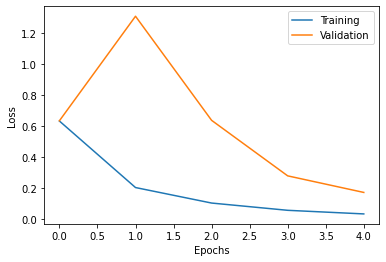

In [16]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], label = "Training")
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

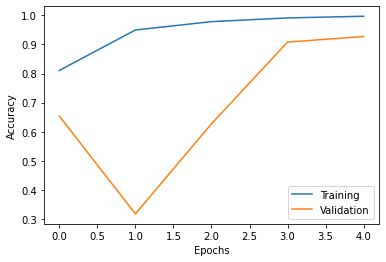

In [17]:
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["accuracy"], label = "Training")
sb.lineplot(x = range(len(history.history["loss"])), y = history.history["val_accuracy"], label = "Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc = "lower right")

In [18]:
result_resnet = model.evaluate(test_data)
print(f"Loss: {result_resnet[0]}")
print(f"Accuracy: {result_resnet[1] }")

5/5 [==============================] - 32s 6s/step - loss: 0.4587 - accuracy: 0.7804
Loss: 0.45866599678993225
Accuracy: 0.7804487347602844
